In [106]:
import pandas as pd
import numpy as np
import re
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import string
import joblib
from collections import Counter
from itertools import chain
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

In [107]:
pd.set_option('display.max_colwidth', 1000)

In [108]:
all_cus_go = pd.read_csv('F:\\mailae_g\\ALL_PL_2022.csv', sep=';')

In [109]:
all_cus_go.head(5)

,Ticket Id,Subject,Description,Source,Requester Email,Created Time,Agent interactions,Customer interactions,Tags
0,111345,[DE] [PYTANIE] B07R42W8J9,Klient ma pytanie do produktu B07R42W8J9: &quot;Jakie połączenie ma dachówka wentylacyjna?&quot; Link do zapytania: www.amazon.de/ask/question/Tx21NZNJ8PMI5JH?_encoding=UTF8&amp;authToken=967c969c-3f2e-47dd-b5e6-faeb39d052d1&amp;ref_=s_respond&amp;answerSolicitationSourceType=EMAIL&amp;answerSolicitationLanguage=de_DE Pozdrawiam Beata,Outbound Email,shop@folnet.de,10 01 2022 10:47,4,4,"Partner_wysłane,rynek_de"
1,128291,[DE] 302-0014409-7188317 NIEKOMPLETNE,"Klient zgłasza, że w zamówieniu nie było lampki. Pozdrawiam, Jakub",Outbound Email,info.palulli@gmail.com,30 01 2022 09:48,3,2,"Partner_wysłane,rynek_de"
2,128325,[REKLAMACJA] 205-9594094-3558723 UK,"Dzień dobry, Klient napisał: Ten produkt dotarł, ale nie działa, nie świeci się. Bardzo rozczarowany, ponieważ kupiłem go dla mojego dziecka. Brak zauważalnych wad, wszystko wydawało się w porządku po otwarciu. Mały przycisk przesuwa się w dół i wydaje się OK, ale nic się nie dzieje, gdy go nacisnąć. To nie świeci się, co było cały punkt z nim, i bardzo rozczarowujące dla mojej córki. Pozdrawiam, Hania",Outbound Email,polskaksiegarniainternetowa@gmail.com,30 01 2022 10:38,2,2,"Partner_wysłane,rynek_uk,Przypomnienie"
3,131092,[DE] [ZAPYTANIE] 305-6969626-5165121,"Klient chciałby wiedzieć, czy materiał, z którego wykonane są klamki może być stosowany również na zewnątrz, np. na bocznych drzwiach wejściowych. Pozdrawiam Beata",Outbound Email,kotarbauzapytania@gmail.com,2 02 2022 16:10,4,4,"Partner_wysłane,rynek_de,Przypomnienie"
4,133983,[IT] 408-8392161-3066735 ZWROT,"https://www.dhl.com/it-en/home/tracking/tracking-parcel.html?submit=1&amp;tracking-id=CM332431606DE Paczka wraca do was, prosimy o refund dla klienta jak dojdzie Kasia",Outbound Email,kotarbauzapytania@gmail.com,7 02 2022 08:58,9,6,"Partner_wysłane,rynek_it,Przypomnienie1,Przypomnienie2"


In [110]:
all_cus_go.reset_index(drop=True, inplace=True)

In [111]:
# Funkcja do dzielenia komórek na listę, pierwszy argument tekst, drugi argument po czym tekst ma być dzielony 

def split_tags(tags: str, split_char: str) -> list:
    try:
        tags = tags.split(f'{split_char}')
        return tags 
    except Exception:
        return (list[tags])
    

In [112]:
# funkcja do wyciągania z listy, jakiego rynku dotyczą wiadomości

def get_market(lst: list) -> str:
    for i in lst:
        if "rynek" in i:
            return i

In [113]:
# funkcja do wyciągania numerów zamówień z tekstu i tytułu maila. Przyjmuje dwa różne ciągi tekstowe, sprawdza czy jest w tytule jest regex, jeśli nie to sprawdza czy jest w opisie, jeśli nie to zwraca pustą listę

se = re.compile(r"\d{3}-\d{7}-\d{7}")

def order_number(subject: str, description: str) -> list:
    subject = str(subject)
    description = str(description)
    if not se.findall(subject):
        return se.findall(description)
    else:
        return se.findall(subject)
    


In [222]:
# funkcja do tworzenia listy unikalnych wartości z kolumn. Dajemy wartość z kolumny i listę. Sprawdza czy wartość już znajduje się na liście, jeśli nie to ją dodaje

def all_order(list_of_values: list, new_list: list) -> list:
    try:
        for i in list_of_values:
            if list_of_values[i] in new_list:
                pass
            else:
                new_list.append(list_of_values[i])
        return new_list
    except Exception:
        i = 1

In [115]:
# czwarta funkcja do czyszczenia tytułów w celu zebrania etykiet do danych

def find_words_with_more_than_four_characters2(subject: str) -> list:
  words = []
  new_subject = ''
  for l in subject:
    l = re.sub('[^A-Za-zĄĆĘŁŃÓŚŹŻąćęłńóśźż]+', ' ', l)
    new_subject += l
  words_temp = new_subject.split(' ')
  for i in words_temp:
    if len(i) >= 4:
      words.append(i)

  return words

In [116]:
# Funkcja do zliczania elementów w liscie, zwraca listę unikatowych wartości i listę unikatowych wartości z informacją ile razy występowały


def count_occurrences(input_list):
    unique_values = set(input_list)
    occurrence_count = Counter(input_list)

    return list(unique_values), occurrence_count

In [117]:
# Funkcja sprawdza czy peirwszy elemnt tupli jest kluczem do słownika, 
# jeśli tak to dodaje 0 elemnt do listy i zwraca set, który zawiera unikatowe wartości dla danego klucza

def find_all_values_to_dictonary (key: str ,list_of_tuple: list) -> set:
    di = []
    for i in list_of_tuple:
        if i[1] == key:
            di.append(i[0])
    return set(di)


In [118]:
def get_all_values (dict1: dict, dict0: dict):
    final_dict = {}
    key_lvl1 = []
    key_lvl1.append(list(dict1.keys()))
    key_lvl1 = list(chain(*key_lvl1))
    not_working_keys = []
    for i in key_lvl1:
        temp_vals = []
        temp_keys = dict1[i]
        temp_keys = [x for x in temp_keys if x is not np.nan]
        for j in temp_keys:
            try:
                temp_vals.append(list(dict0[j]))
            except Exception:
                    not_working_keys.append(j)
        temp_vals = set(item for sublist in temp_vals for item in sublist)
        final_dict[i] = temp_vals
    return not_working_keys, final_dict

In [119]:
def get_all_values2(dict1: dict, dict0: dict):
    final_dict = {}
    not_working_keys = []

    for key, values in dict1.items():
        valid_values = [v for v in values if v is not np.nan]
        temp_vals = []

        for v in valid_values:
            try:
                temp_vals.extend(dict0[v])
            except Exception:
                not_working_keys.append(v)

        final_dict[key] = set(temp_vals)

    return not_working_keys, final_dict

In [120]:
def title_classification (dict_of_words: dict, title: list) -> str:
    if len(title) > 0:
        for key, values in dict_of_words.items():
            for i in title:
                if i in values:
                    return key

In [121]:
# Zmiana tytułów na lowercase

# all_amz_go['Subject'] = [str(row).lower() for row in all_amz_go['Subject']]
all_cus_go['Subject'] = [str(row).lower() for row in all_cus_go['Subject']]

In [122]:
# przekształcenie stringów w komórkach kolumny tags na listę, dzielone po przecinku 

# all_amz_go['Tags'] = [split_tags(row, ',')for row in all_amz_go['Tags']]
all_cus_go['Tags'] = [split_tags(row, ',')for row in all_cus_go['Tags']]

In [123]:
all_cus_go["Tags"].head()

0                                    [Partner_wysłane, rynek_de]
1                                    [Partner_wysłane, rynek_de]
2                     [Partner_wysłane, rynek_uk, Przypomnienie]
3                     [Partner_wysłane, rynek_de, Przypomnienie]
4    [Partner_wysłane, rynek_it, Przypomnienie1, Przypomnienie2]
Name: Tags, dtype: object

In [124]:
# utworzenie kolumny, w której jest napisane jakiego rynku dotyczy wiadomość, na podstawie kolumny tags

# all_amz_go['rynek'] = [get_market(row) for row in all_amz_go['Tags']]
all_cus_go['rynek'] = [get_market(row) for row in all_cus_go['Tags']]

In [125]:
# usunięcie wierszy, które w kolumnie 'rynek' nie maję 'rynek_de'

# all_amz_go.drop(all_amz_go[all_amz_go['rynek'] != 'rynek_de'].index,  inplace=True)
# all_cus_go.drop(all_cus_go[all_cus_go['rynek'] != 'rynek_de'].index,  inplace=True)

In [126]:
# wyciągnięcie numeru zamówień z kolumn subject i description

# all_amz_go['Order_number'] = [order_number(row1, row2) for row1, row2 in zip(all_amz_go['Subject'], all_amz_go['Description'])]
all_cus_go['Order_number'] = [order_number(row1, row2) for row1, row2 in zip(all_cus_go['Subject'], all_cus_go['Description'])]

In [127]:
# resetowanie indexów

# all_amz_go.reset_index(drop=True, inplace=True)
all_cus_go.reset_index(drop=True, inplace=True)

In [128]:
# zmiana obiektów z kolummny 'Created Time' na daty

from datetime import datetime

format_date = "%d %m %Y %H:%M"

# all_amz_go['Created Time'] = [datetime.strptime(row, format_date) for row in all_amz_go['Created Time']] 
all_cus_go['Created Time'] = [datetime.strptime(row, format_date) for row in all_cus_go['Created Time']] 

In [129]:
# wykorzystanie funkcji do splitowania aby utworzyć kolumnę 

# all_amz_go['title_list'] = [split_tags(row, ' ') for row in all_amz_go['Subject']]
all_cus_go['title_list'] = [split_tags(row, ' ') for row in all_cus_go['Subject']]
all_cus_go['title_list'].head()

0                [[de], [pytanie], b07r42w8j9]
1    [[de], 302-0014409-7188317, niekompletne]
2      [[reklamacja], 205-9594094-3558723, uk]
3     [[de], [zapytanie], 305-6969626-5165121]
4           [[it], 408-8392161-3066735, zwrot]
Name: title_list, dtype: object

In [130]:
# sprawdzenie czy funcja split_tags zadzaiała poprawnie

all_cus_go['title_list'][1]

['[de]', '302-0014409-7188317', 'niekompletne']

W tym momencie postanowieł sprawdzić, czy zamówienia, z jednej i drugiej tabeli się pokrywają w jakimś najmniejszym stopniu

In [131]:
# # za pomocą wcześniej stworzonej funkcji tworzę listę unikatowych numerów ze wszystkich wierszy jednego data set

# all_amz_go_list = []
# # [all_order(row, all_amz_go_list) for row in all_amz_go['Order_number']]
# all_amz_go_list = [item for sublist in all_amz_go_list for item in sublist]

In [132]:
# # za pomocą wcześniej stworzonej funkcji tworzę listę unikatowych numerów ze wszystkich wierszy drugiego data set

# all_cus_go_list = []
# [all_order(row, all_cus_go_list) for row in all_cus_go['Order_number']]
# all_cus_go_list = [item for sublist in all_cus_go_list for item in sublist]

In [133]:
# # zamieniam stworzyonych list na set

# mcg_order_set = set(all_amz_go_list)
# mag_rynek_de_order_set = set(all_cus_go_list)

In [134]:
# # dodanie kontrolnie jednej takiej samej wartości do obu setów

# mcg_order_set.add('123')
# mag_rynek_de_order_set.add('123')

In [135]:
# # porównanie dwóch

# y = mcg_order_set.intersection(mag_rynek_de_order_set)

In [136]:
# # Wyświetlenie ile mamy takich samych numerów zamówień w jednym i drugim secie

# len(y)

Powrót do preprocesingu danych

In [137]:
# weryfickaja działania funkcji do czyszczenia tytułów maili

print(find_words_with_more_than_four_characters2(all_cus_go['Subject'][5552]))

['zapytanie', 'amandine', 'perez']


In [138]:
# utworzenie nowej kolumny label i dodanie do niej słów, które nadają się na labelki

all_cus_go['label'] = [find_words_with_more_than_four_characters2(row) for row in all_cus_go['Subject']]

In [207]:
all_cus_go.head()

,Ticket Id,Subject,Description,Source,Requester Email,Created Time,Agent interactions,Customer interactions,Tags,rynek,Order_number,title_list,label,final_label
0,111345,[de] [pytanie] b07r42w8j9,Klient ma pytanie do produktu B07R42W8J9: &quot;Jakie połączenie ma dachówka wentylacyjna?&quot; Link do zapytania: www.amazon.de/ask/question/Tx21NZNJ8PMI5JH?_encoding=UTF8&amp;authToken=967c969c-3f2e-47dd-b5e6-faeb39d052d1&amp;ref_=s_respond&amp;answerSolicitationSourceType=EMAIL&amp;answerSolicitationLanguage=de_DE Pozdrawiam Beata,Outbound Email,shop@folnet.de,2022-01-10 10:47:00,4,4,"[Partner_wysłane, rynek_de]",rynek_de,[],"[[de], [pytanie], b07r42w8j9]",[pytanie],zapytanie
1,128291,[de] 302-0014409-7188317 niekompletne,"Klient zgłasza, że w zamówieniu nie było lampki. Pozdrawiam, Jakub",Outbound Email,info.palulli@gmail.com,2022-01-30 09:48:00,3,2,"[Partner_wysłane, rynek_de]",rynek_de,[302-0014409-7188317],"[[de], 302-0014409-7188317, niekompletne]",[niekompletne],niekompletne
2,128325,[reklamacja] 205-9594094-3558723 uk,"Dzień dobry, Klient napisał: Ten produkt dotarł, ale nie działa, nie świeci się. Bardzo rozczarowany, ponieważ kupiłem go dla mojego dziecka. Brak zauważalnych wad, wszystko wydawało się w porządku po otwarciu. Mały przycisk przesuwa się w dół i wydaje się OK, ale nic się nie dzieje, gdy go nacisnąć. To nie świeci się, co było cały punkt z nim, i bardzo rozczarowujące dla mojej córki. Pozdrawiam, Hania",Outbound Email,polskaksiegarniainternetowa@gmail.com,2022-01-30 10:38:00,2,2,"[Partner_wysłane, rynek_uk, Przypomnienie]",rynek_uk,[205-9594094-3558723],"[[reklamacja], 205-9594094-3558723, uk]",[reklamacja],reklamacja
3,131092,[de] [zapytanie] 305-6969626-5165121,"Klient chciałby wiedzieć, czy materiał, z którego wykonane są klamki może być stosowany również na zewnątrz, np. na bocznych drzwiach wejściowych. Pozdrawiam Beata",Outbound Email,kotarbauzapytania@gmail.com,2022-02-02 16:10:00,4,4,"[Partner_wysłane, rynek_de, Przypomnienie]",rynek_de,[305-6969626-5165121],"[[de], [zapytanie], 305-6969626-5165121]",[zapytanie],zapytanie
4,133983,[it] 408-8392161-3066735 zwrot,"https://www.dhl.com/it-en/home/tracking/tracking-parcel.html?submit=1&amp;tracking-id=CM332431606DE Paczka wraca do was, prosimy o refund dla klienta jak dojdzie Kasia",Outbound Email,kotarbauzapytania@gmail.com,2022-02-07 08:58:00,9,6,"[Partner_wysłane, rynek_it, Przypomnienie1, Przypomnienie2]",rynek_it,[408-8392161-3066735],"[[it], 408-8392161-3066735, zwrot]",[zwrot],zwrot


In [223]:
# Stworzenie listy ze wszystkimi wartościami z kolumny labels

label_list = []
[all_order(row, label_list) for row in all_cus_go['label']]
label_list = [item for sublist in label_list for item in sublist]

In [ ]:

label_list = [1]
all_order([1,3,4,1],label_list)
print(label_list)

[1, 3]


In [189]:
unique_values = all_cus_go['label'].explode().unique()

In [212]:
len(unique_values)

4800

In [213]:
label_list

[]

In [140]:
# Stworzenie dwóch list na podstawie listy wartości z kolumny['label'], jedna lista to unikatowe wartości, druga lista unikatowe wartości z informacją ile dana wartość występowała

uniq_vales, uniq_values_count = count_occurrences(label_list)

In [195]:
len(uniq_vales)

4799

In [141]:
# Stworzenie obiektu spacy z polskim słownikiem

nlp = spacy.load("pl_core_news_lg")

In [142]:
# Zmiana unikatowej listy na string

uniq_vales_sentence = ' '.join(uniq_vales)

In [143]:
# tokenizacja stringu unikatowych wartości z kolumny tags

doc = nlp(uniq_vales_sentence)

In [144]:
# lemantyzacja wcześniej stworzonych tokenów. Stworzenie listy i listy tupli. Lista tupli zawierające słowo i jej podstawę słowotwórczą, sama lista zawiera wszystkie podstwy słowotwórcze 

all_lem = []
all_words = []
for token in doc:
    all_words.append((token.text, token.lemma_))
    all_lem.append(token.lemma_)

In [145]:
# import pickle
# with open('all_lem.pkl', 'wb') as file:
#     pickle.dump(all_lem, file)

In [146]:
# stworzenie słownika ze specjalnego obieku counter

uniq_values_count_dict = dict(uniq_values_count)

In [147]:
# Stworzenie słownika gdzie klucz to podstawa słowotwórcza a values jest listą słów dla tej podstawy występująca w kolumnie tags

lem_dict_0 = {}
for i in set(all_lem):
    lem_dict_0[i] = find_all_values_to_dictonary(i,all_words)

In [148]:
# Stworzenie słownika, gdzie klucz to podstawa słwowtwórcza, a values to suma wartości występowania słów zawiązanych z tą lemą

number_of_occurence = {}
for i in lem_dict_0:
    number_of_occurence_value = []
    for j in lem_dict_0[i]:
        number_of_occurence_value.append(uniq_values_count_dict[j])
    number_of_occurence[i] = sum(number_of_occurence_value)

In [149]:
# Posortowanie słownika zawierającego podstawę słowotwórczą oraz ilość wystąpnień słów z nim powiązanych

number_of_occurence_sorted = sorted(number_of_occurence.items(), key=lambda x:x[1], reverse=True)

In [150]:
labels_df = pd.read_csv('labels2.csv', sep=';', header=None)
labels_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,anulacja,anulować,anulacja,anulowac,anulacj,anulownie,anulownaie,nieanulowanie,anulaj,anuloewanie,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,reklamacja,reklamacja,reklamation,reklamcja,reklaamcja,reklamajci,reklmacja,reklacja,reklama,reklamationa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,wysyłka,wysyłce,wysyłka,wysyłke,wysyp,wysylce,wysyłkąć,wysyka,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,refund,refund,refundacja,refunda,refunf,refung,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,przesyłka,przesyłka,przesylka,przesyłewka,przesyłkami,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
labels_df = labels_df.T
labels_df.columns = labels_df.iloc[0]
label_name = labels_df.iloc[0]
labels_df = labels_df[1:]

In [152]:
lem_dict_1 = labels_df.to_dict(orient='list')

In [153]:
not_working_keys, final_dict = get_all_values(lem_dict_1, lem_dict_0)

In [154]:
len(not_working_keys)

59

In [155]:
all_cus_go['final_label'] = [title_classification(final_dict, row) for row in all_cus_go['label']]

In [156]:
def set_day_to_first_of_month(date_string):
    date_obj = datetime.strptime(date_string, "%Y-%m-%d")
    date_obj = date_obj.replace(day=1)
    new_date_string = date_obj.strftime("%Y-%m-%d")
    return new_date_string

In [157]:

all_cus_go_plots = pd.DataFrame(all_cus_go[['final_label','Created Time','Requester Email','Agent interactions','Customer interactions','rynek',]])

all_cus_go_plots['rynek'] = all_cus_go['rynek'].str.replace('rynek_', '').str.replace('rynek ', '').str.replace('usa','us')
all_cus_go_plots['rynek'] = all_cus_go_plots['rynek'].str.upper()
all_cus_go_plots['counter'] = 1
all_cus_go_plots.head()

,final_label,Created Time,Requester Email,Agent interactions,Customer interactions,rynek,counter
0,zapytanie,2022-01-10 10:47:00,shop@folnet.de,4,4,DE,1
1,niekompletne,2022-01-30 09:48:00,info.palulli@gmail.com,3,2,DE,1
2,reklamacja,2022-01-30 10:38:00,polskaksiegarniainternetowa@gmail.com,2,2,UK,1
3,zapytanie,2022-02-02 16:10:00,kotarbauzapytania@gmail.com,4,4,DE,1
4,zwrot,2022-02-07 08:58:00,kotarbauzapytania@gmail.com,9,6,IT,1


In [158]:
test = all_cus_go_plots[all_cus_go_plots['final_label'] == 'ponowna']
print(test)

      final_label        Created Time           Requester Email  \
562       ponowna 2022-12-29 18:26:00     contact@granmaster.eu   
1429      ponowna 2022-12-30 13:09:00   mail.eugenius@gmail.com   
2054      ponowna 2022-12-30 09:35:00  amazon.de@morele.systems   
2100      ponowna 2022-09-25 08:26:00   ewaskiba@basspolska.com   
3735      ponowna 2022-12-20 19:59:00          p.wilk@aleeko.pl   
...           ...                 ...                       ...   
56218     ponowna 2023-04-09 09:05:00                       NaN   
56334     ponowna 2023-04-18 18:12:00                       NaN   
56835     ponowna 2023-03-12 08:32:00                       NaN   
57466     ponowna 2023-02-14 20:43:00                       NaN   
57711     ponowna 2023-01-25 19:00:00                       NaN   

       Agent interactions  Customer interactions rynek  counter  
562                     2                      3    DE        1  
1429                    1                      1    DE        1

In [159]:
all_cus_go_plots.reset_index(inplace=True)
all_cus_go_plots['Created Time'] = pd.to_datetime(all_cus_go_plots['Created Time'])

all_cus_go_plots = all_cus_go_plots.dropna(subset=['final_label'])

all_cus_go_plots.set_index('Created Time', inplace=True)

pivot_count_df = all_cus_go_plots.pivot_table(
    index=all_cus_go_plots.index,
    columns='final_label',
    values='counter',
    aggfunc='sum'
)

pivot_count_df = pivot_count_df.resample('M').sum()

pivot_count_df.head()


final_label,adres,anulacja,brak,dostawa,faktura,inne,niekompletne,opóźnienie,paczka,ponowna,przesyłka,refund,reklamacja,uszkodzony,wysyłka,zapytanie,zwrot
Created Time,,,,,,,,,,,,,,,,,
2022-01-31,41.0,175.0,21.0,29.0,2.0,0.0,26.0,3.0,18.0,1.0,1.0,38.0,42.0,8.0,15.0,15.0,160.0
2022-02-28,23.0,125.0,23.0,18.0,9.0,1.0,19.0,1.0,7.0,0.0,1.0,13.0,33.0,9.0,9.0,15.0,121.0
2022-03-31,31.0,130.0,10.0,26.0,8.0,1.0,14.0,0.0,13.0,21.0,3.0,18.0,25.0,5.0,9.0,20.0,78.0
2022-04-30,37.0,135.0,19.0,51.0,4.0,0.0,8.0,3.0,12.0,4.0,9.0,16.0,44.0,4.0,19.0,17.0,98.0
2022-05-31,43.0,129.0,15.0,37.0,10.0,0.0,14.0,1.0,15.0,2.0,0.0,23.0,44.0,5.0,9.0,16.0,117.0


In [160]:
all_cus_go_plots.reset_index(inplace=True)
all_cus_go_plots_count = pd.DataFrame(all_cus_go_plots[['Created Time','counter']])
all_cus_go_plots_count.set_index('Created Time', inplace=True)
all_cus_go_plots_count = all_cus_go_plots_count.resample('M').sum()
all_cus_go_plots_count.head()

,counter
Created Time,
2022-01-31,595
2022-02-28,427
2022-03-31,412
2022-04-30,480
2022-05-31,480


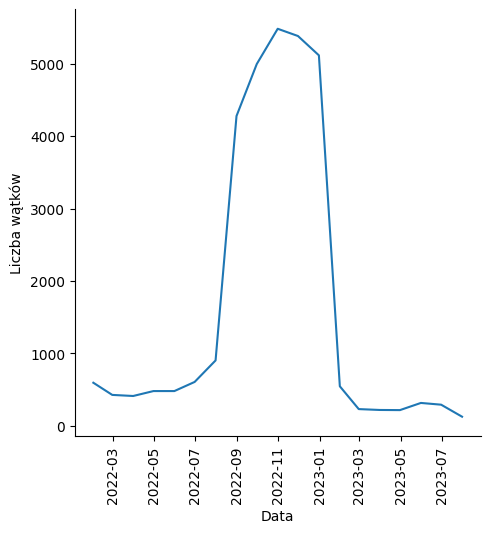

In [161]:
g = sns.relplot(x="Created Time",
            y="counter",
            data=all_cus_go_plots_count,
            kind="line")

# g.set_title("Liczba wiadomości w ciągu miesiąca")
g.set(xlabel="Data",
      ylabel="Liczba wątków")
plt.xticks(rotation=90)
plt.show()

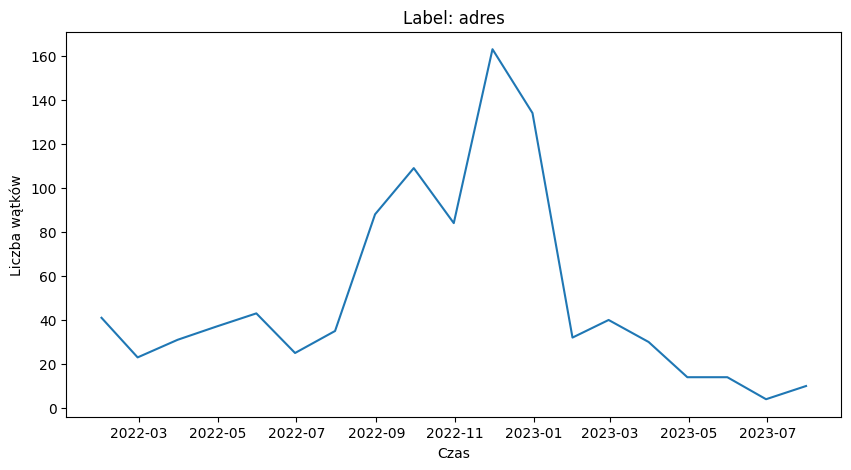

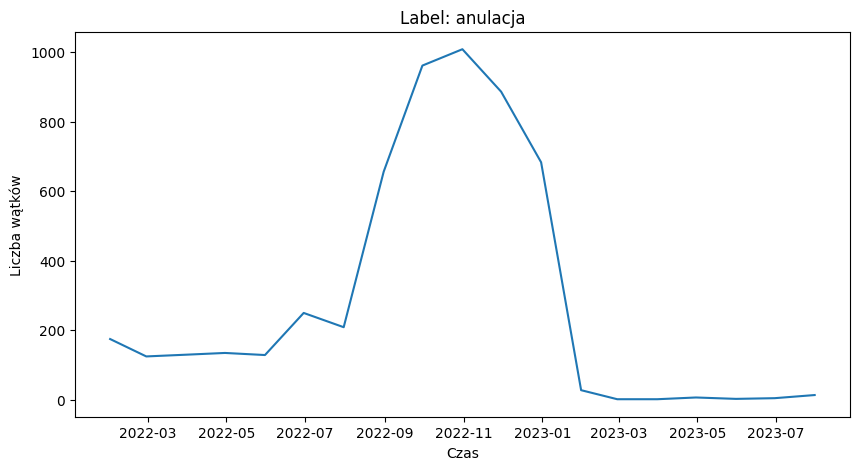

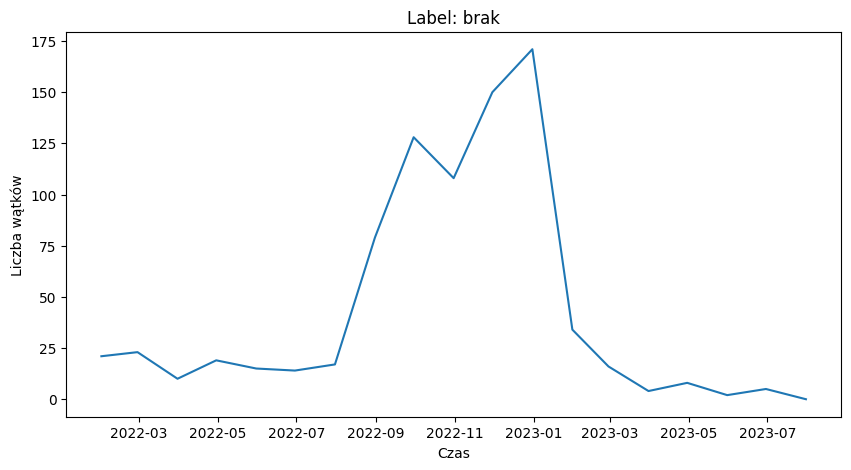

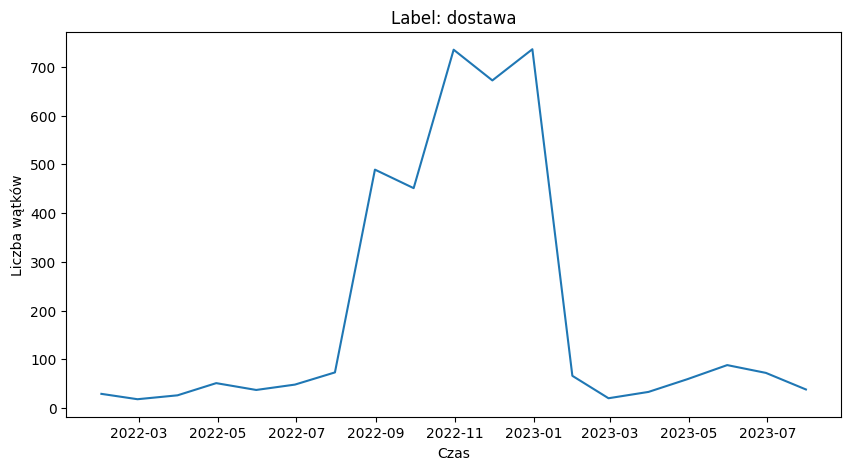

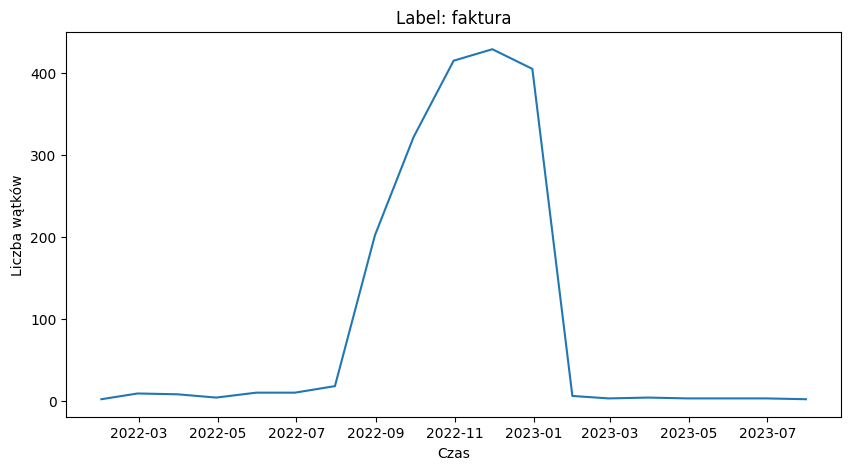

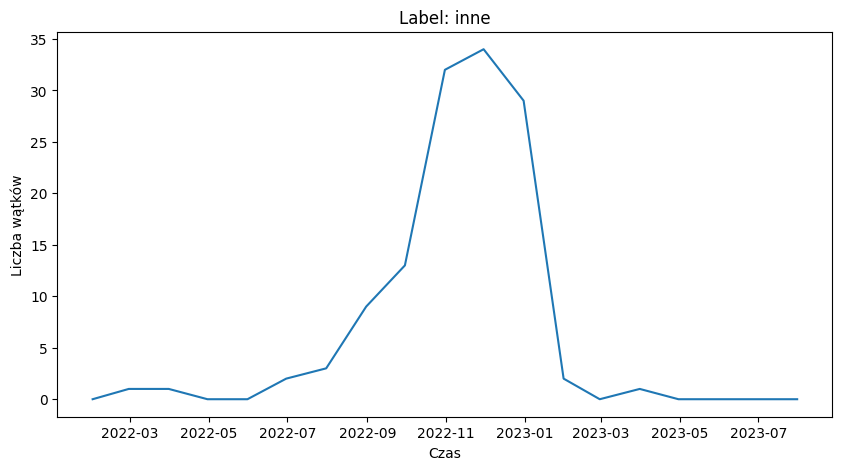

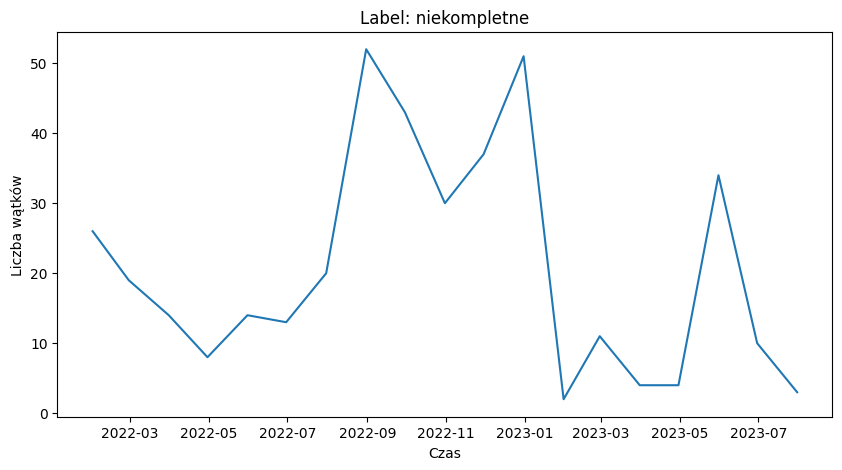

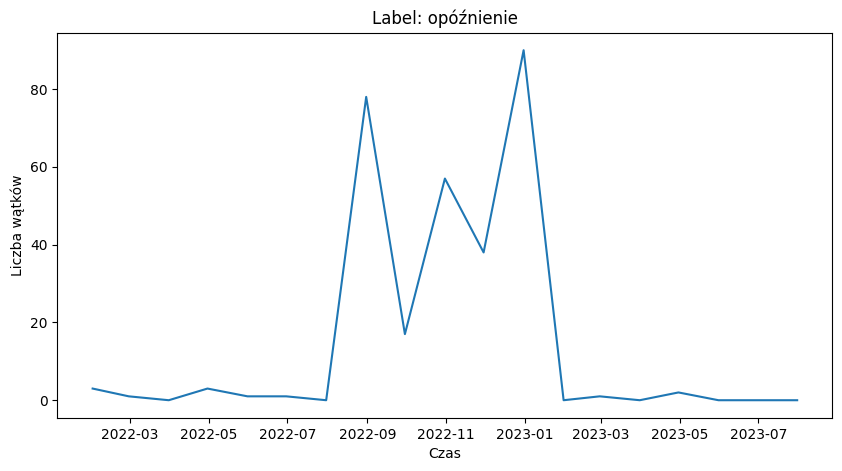

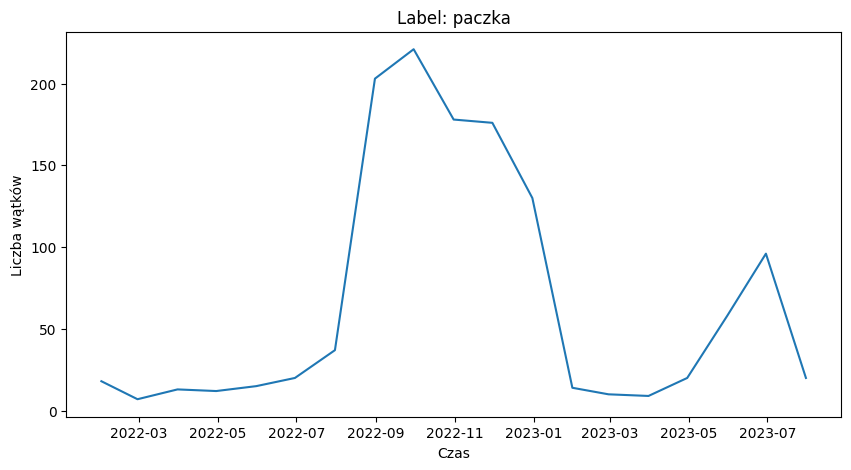

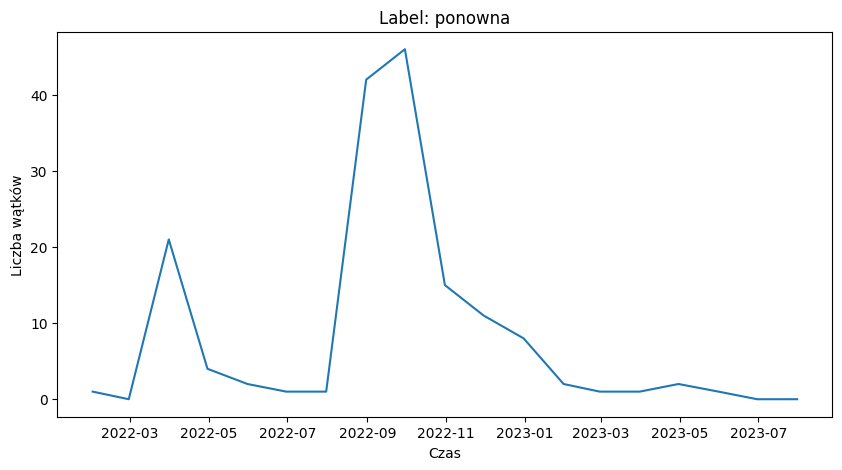

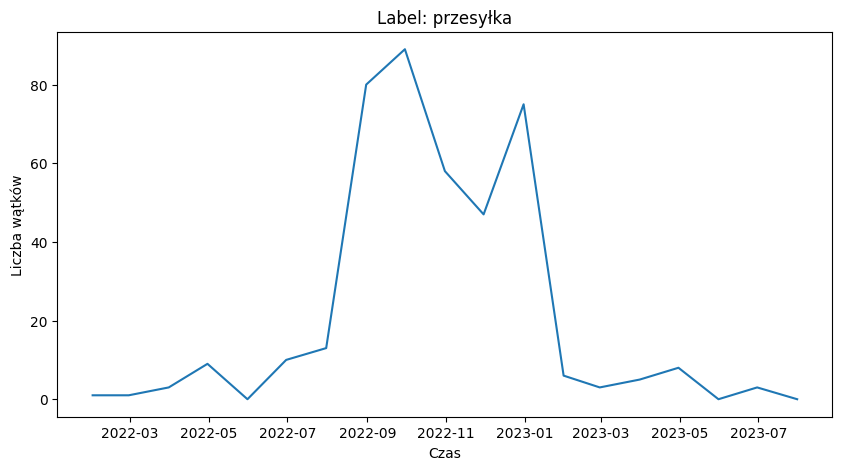

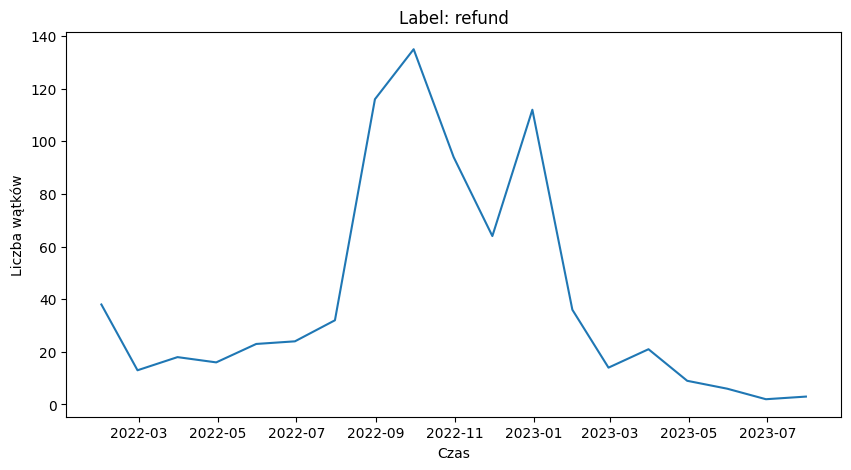

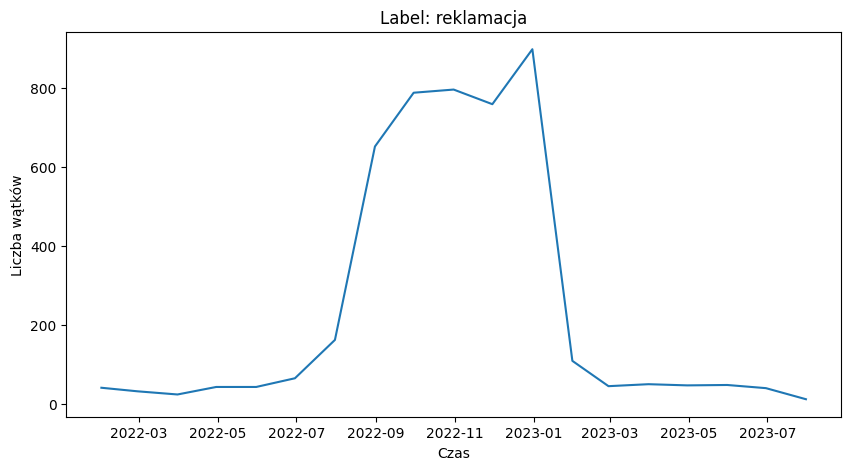

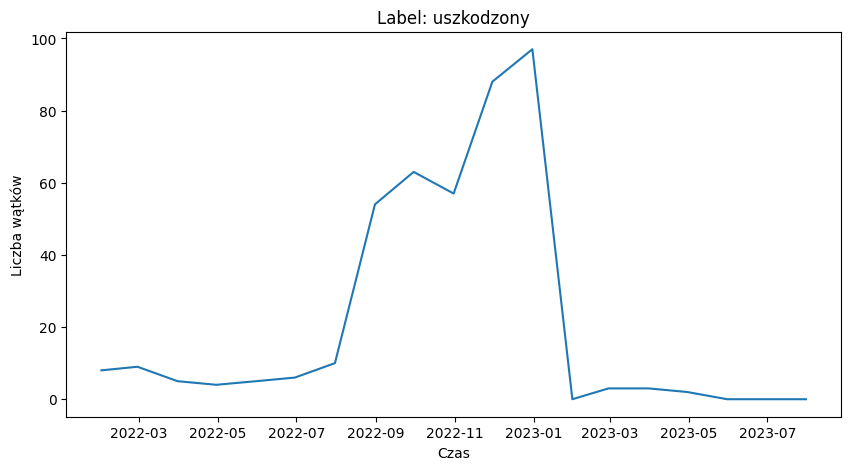

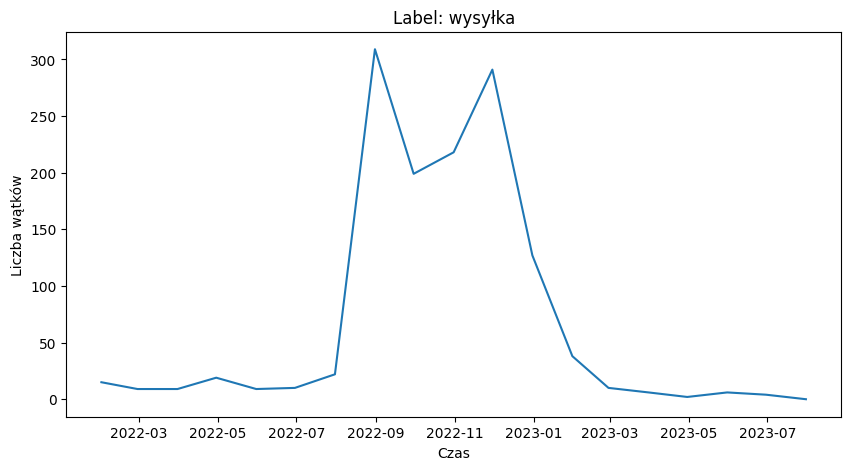

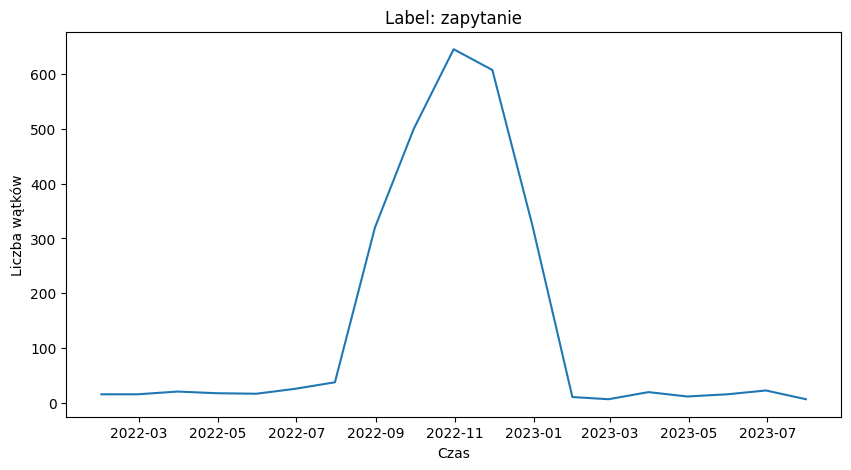

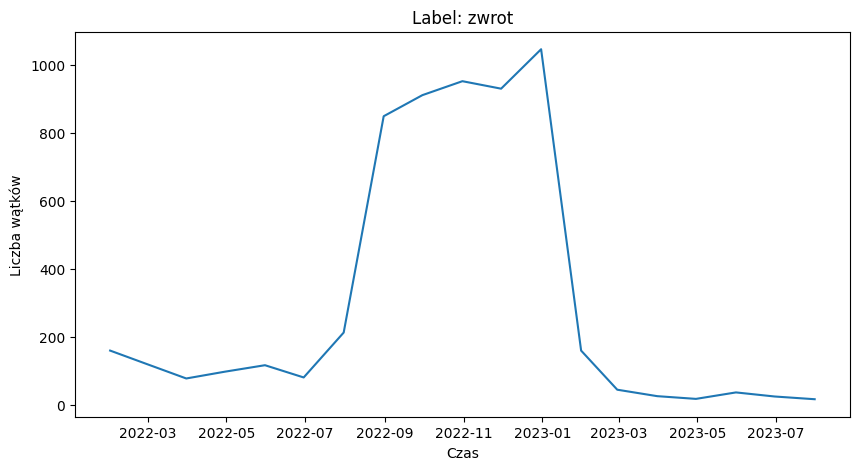

In [162]:
for column_name in pivot_count_df.columns:
    # Create a new figure for each column
    plt.figure(figsize=(10, 5))
    
    # Plot the data for the current column
    sns.lineplot(x="Created Time",
                 y=column_name,
                 data=pivot_count_df)

    plt.xlabel("Czas")
    plt.ylabel("Liczba wątków")
    plt.title(f"Label: {column_name}")

    # Show the current figure
    plt.show()

In [163]:
all_cus_go_plots.reset_index(inplace=True)
all_cus_go_plots['Created Time'] = pd.to_datetime(all_cus_go_plots['Created Time'])

pivot_df = all_cus_go_plots.pivot_table(index='Created Time', columns='final_label', values=['Agent interactions', 'Customer interactions'], aggfunc='mean')

pivot_df.columns = [f'{col[1]}_{col[0]}' for col in pivot_df.columns]

pivot_df.reset_index(inplace=True)

pivot_df.set_index('Created Time', inplace=True)
pivot_df = pivot_df.resample('M').mean()
pivot_df.head()

,adres_Agent interactions,anulacja_Agent interactions,brak_Agent interactions,dostawa_Agent interactions,faktura_Agent interactions,inne_Agent interactions,niekompletne_Agent interactions,opóźnienie_Agent interactions,paczka_Agent interactions,ponowna_Agent interactions,...,opóźnienie_Customer interactions,paczka_Customer interactions,ponowna_Customer interactions,przesyłka_Customer interactions,refund_Customer interactions,reklamacja_Customer interactions,uszkodzony_Customer interactions,wysyłka_Customer interactions,zapytanie_Customer interactions,zwrot_Customer interactions
Created Time,,,,,,,,,,,,,,,,,,,,,
2022-01-31,1.195122,1.502857,1.952381,3.000000,1.500000,NaN,2.769231,1.333333,1.722222,2.000000,...,1.666667,1.611111,2.0,1.000000,1.552632,2.285714,1.875000,1.266667,1.933333,1.638365
2022-02-28,1.782609,1.288000,2.173913,2.611111,1.333333,1.0,2.684211,4.000000,1.285714,NaN,...,2.000000,1.285714,NaN,1.000000,1.230769,2.696970,1.777778,1.444444,1.866667,2.033613
2022-03-31,1.290323,1.360465,1.700000,1.615385,1.875000,7.0,3.285714,NaN,1.538462,1.047619,...,NaN,1.384615,1.0,1.000000,1.444444,2.640000,2.000000,2.777778,1.550000,1.628205
2022-04-30,1.432432,1.338346,2.368421,1.823529,5.750000,NaN,4.000000,3.666667,2.083333,1.000000,...,3.000000,1.833333,1.0,0.666667,0.937500,3.500000,2.000000,1.315789,1.176471,1.693878
2022-05-31,1.697674,1.610236,2.600000,2.702703,2.900000,NaN,3.357143,10.000000,2.133333,1.000000,...,12.000000,2.066667,1.0,NaN,1.086957,3.000000,3.750000,1.888889,1.187500,1.965812


In [164]:
# all_cus_go_plots.reset_index(inplace=True)
# all_cus_go_plots_date = pd.DataFrame(all_cus_go_plots[['Created Time','Agent interactions','Customer interactions']])
# all_cus_go_plots_date.set_index('Created Time', inplace=True)
# all_cus_go_plots_date = all_cus_go_plots_date.resample('M').mean()
# all_cus_go_plots_date.head()

In [165]:
# sns.lineplot(x="Created Time",
#                 y="Agent interactions",
#                 data=all_cus_go_plots_date,
#                 )
# sns.lineplot(x="Created Time",
#                 y="Customer interactions",
#                 data=all_cus_go_plots_date,
#                 )

# plt.xticks(rotation=90)
# plt.xlabel("Czas")
# plt.ylabel("Średnia liczba interakcji w wątku")

# plt.show()

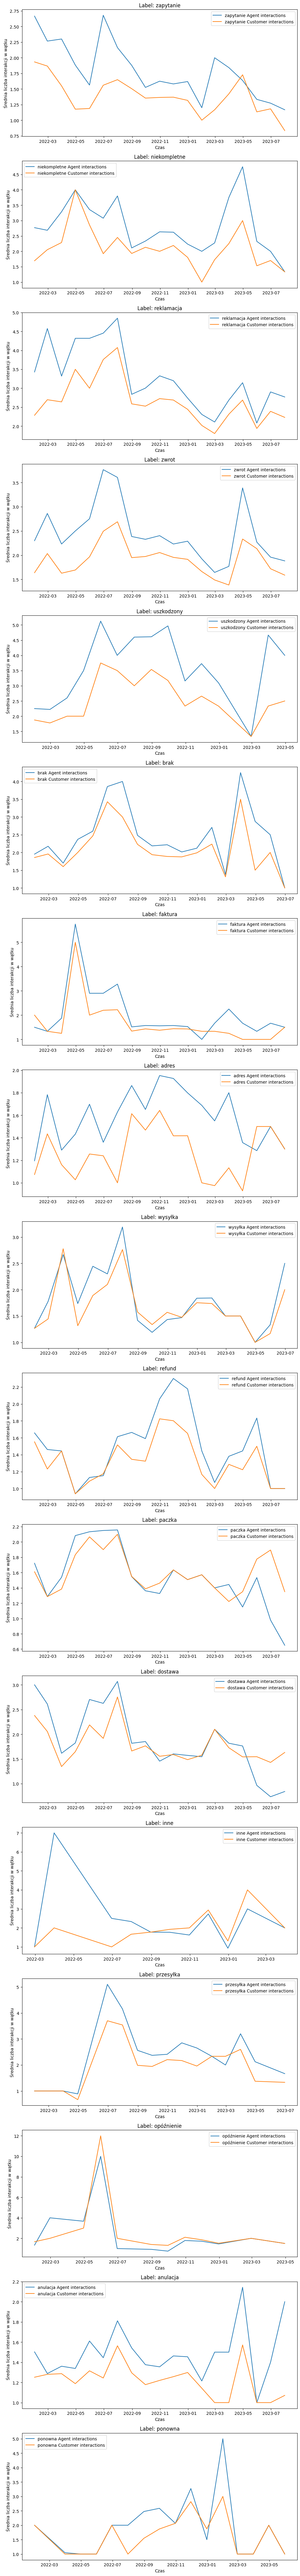

In [166]:
labels = ['zapytanie', 'niekompletne', 'reklamacja', 'zwrot', 
       'uszkodzony', 'brak', 'faktura', 'adres', 'wysyłka', 'refund',
       'paczka', 'dostawa', 'inne', 'przesyłka', 'opóźnienie', 'anulacja',
       'ponowna']

# Create subplots for each label
fig, axes = plt.subplots(nrows=len(labels), figsize=(10, 5 * len(labels)))

for i, label in enumerate(labels):
    ax = axes[i]

    # Filter the columns related to the current label
    label_cols = [col for col in pivot_df.columns if col.startswith(label)]

    # Plot the data for "Agent interactions"
    sns.lineplot(x="Created Time",
                 y=label_cols[0],
                 data=pivot_df,
                 ax=ax,
                 label=f"{label} Agent interactions")

    # Plot the data for "Customer interactions"
    sns.lineplot(x="Created Time",
                 y=label_cols[1],
                 data=pivot_df,
                 ax=ax,
                 label=f"{label} Customer interactions")

    ax.set_xlabel("Czas")
    ax.set_ylabel("Średnia liczba interakcji w wątku")
    # ax.set_xticklabels(pivot_df["Created Time"], rotation=90)  # Optional, adjust the x-axis labels

    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

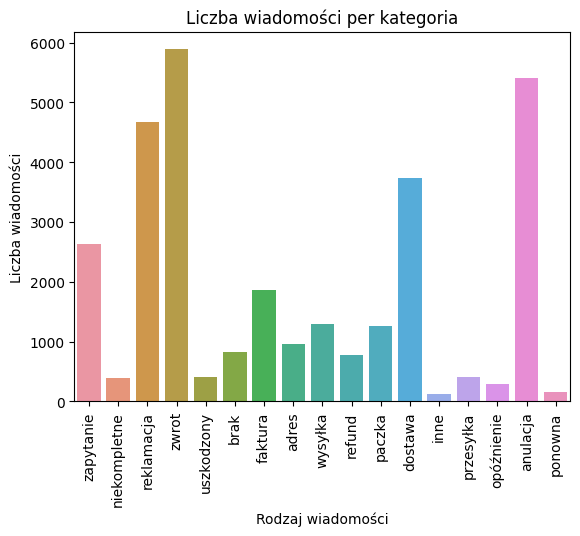

In [167]:
g = sns.countplot(x=all_cus_go['final_label'])

g.set_title("Liczba wiadomości per kategoria")
g.set(xlabel="Rodzaj wiadomości",
      ylabel="Liczba wiadomości")
plt.xticks(rotation=90)
plt.show()

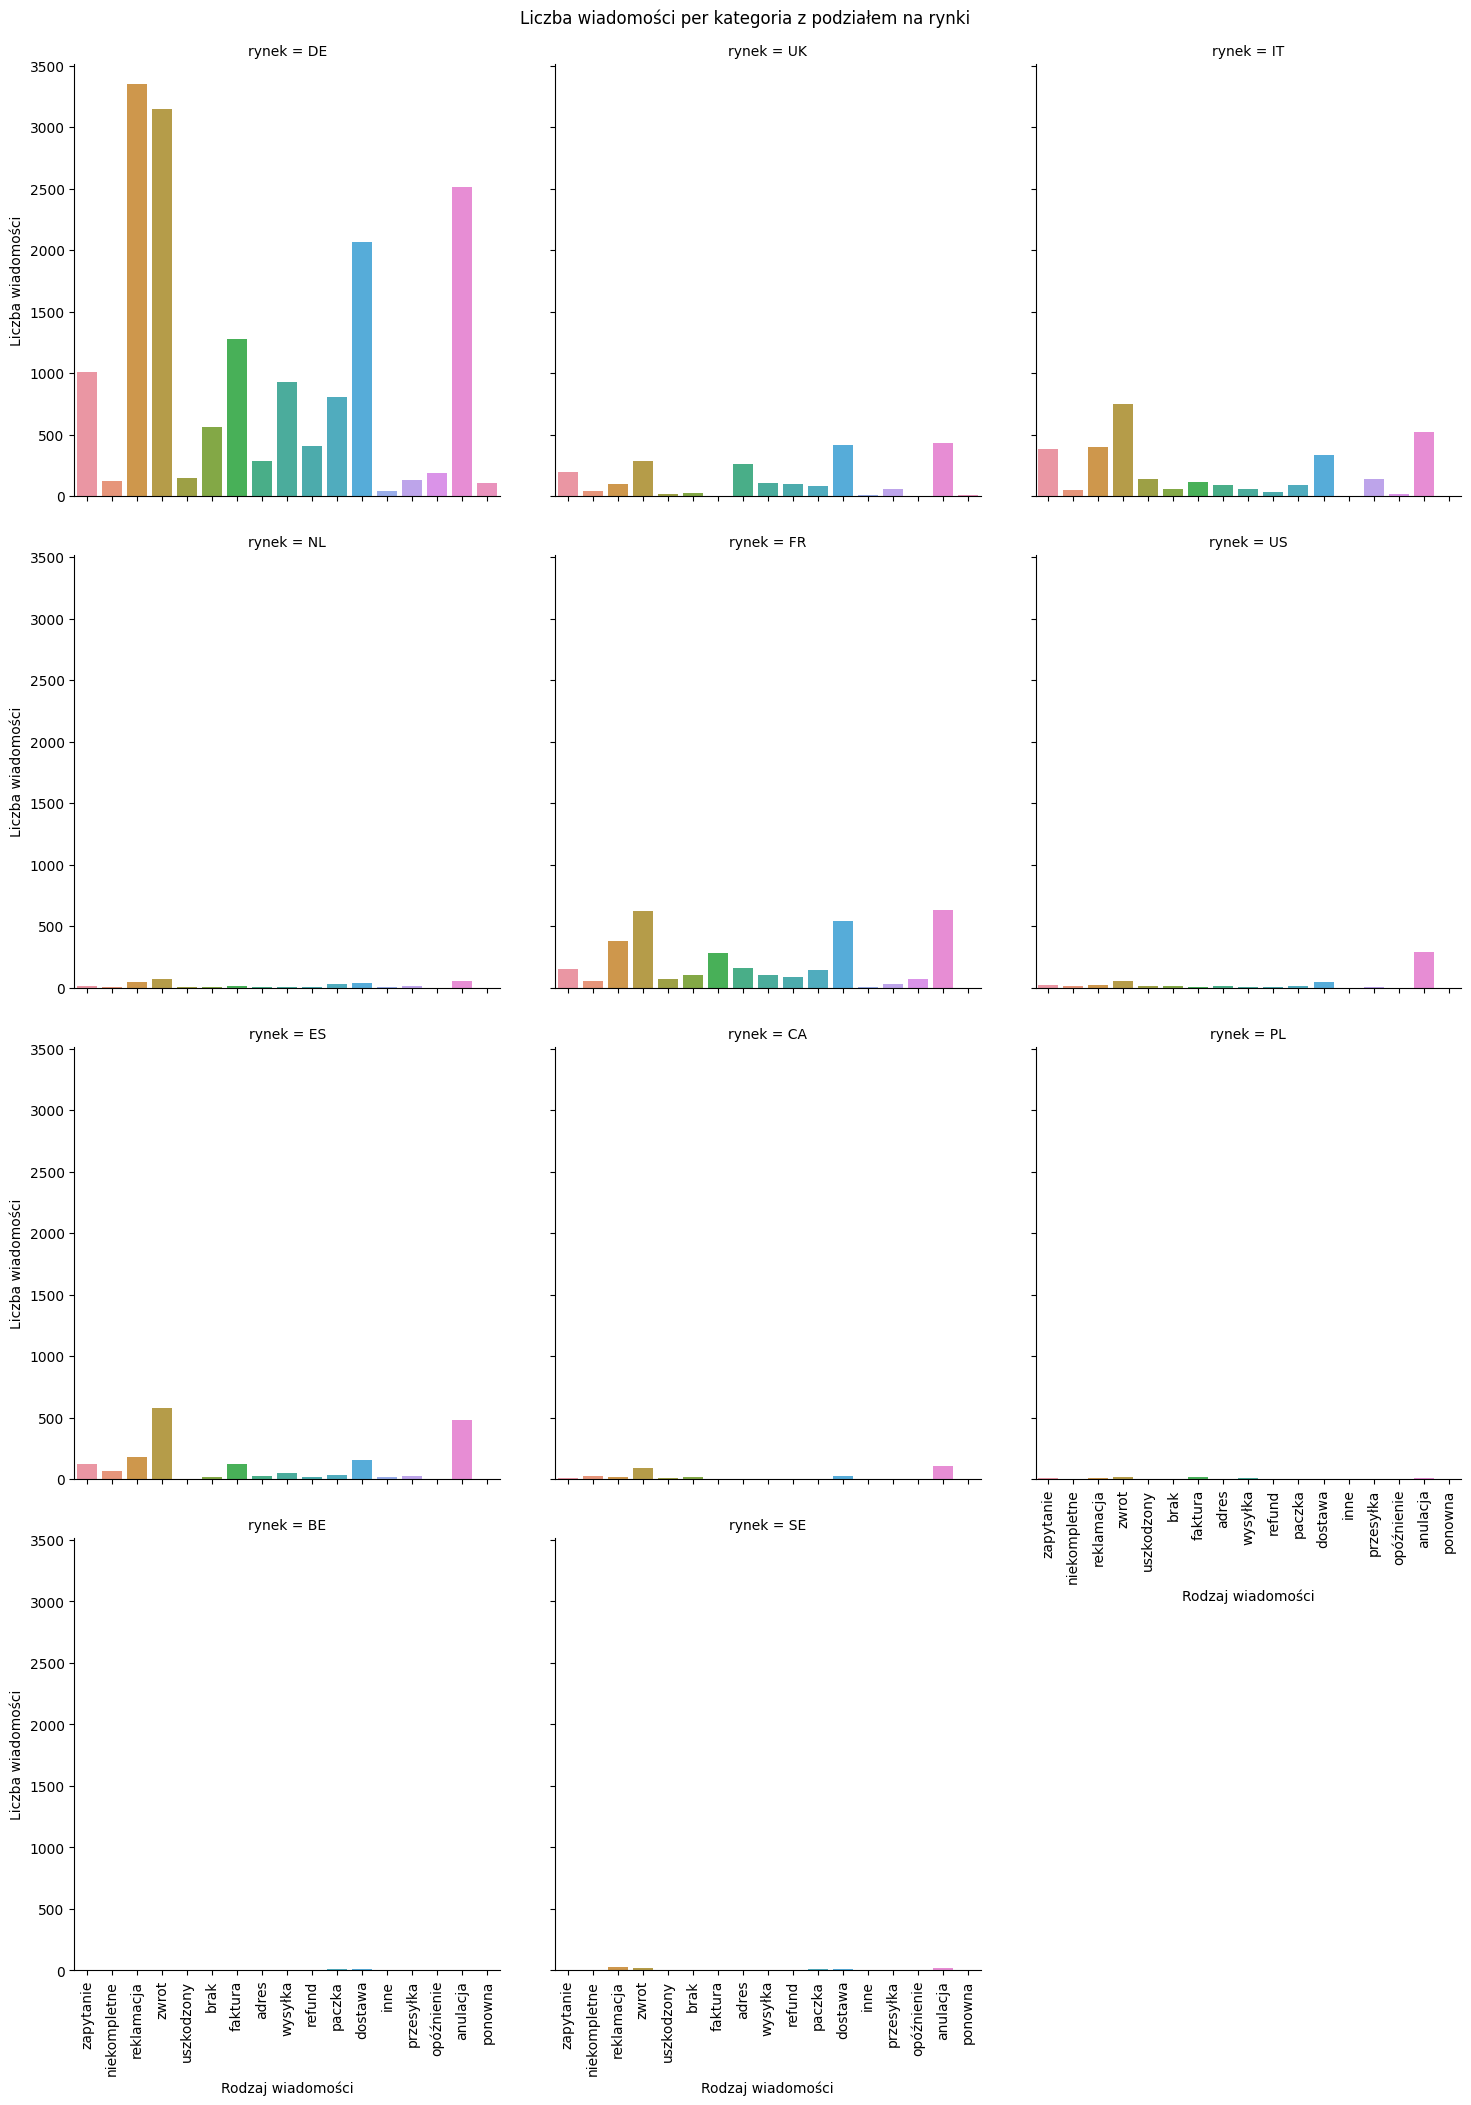

In [168]:
g = sns.catplot(x='final_label',
            data=all_cus_go_plots,
            kind='count',
            col="rynek",
            col_wrap=3)

g.fig.suptitle("Liczba wiadomości per kategoria z podziałem na rynki", y=1.01)
g.set_axis_labels("Rodzaj wiadomości", "Liczba wiadomości")


for ax in g.axes.flat:
    plt.sca(ax)
    plt.xticks(rotation=90)

# plt.show()

plt.show()

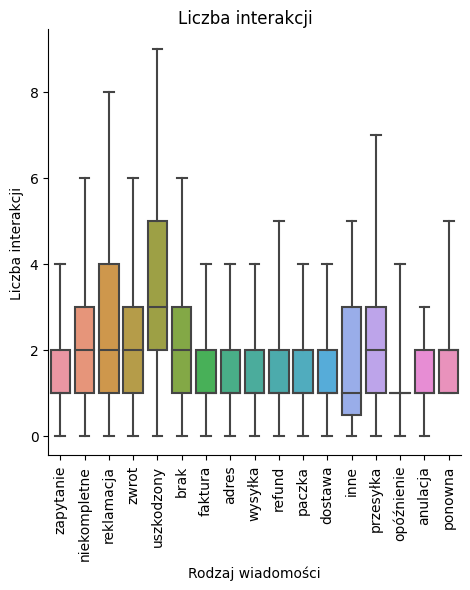

In [169]:
g = sns.catplot(y='Agent interactions',
                x='final_label',
                data=all_cus_go_plots,
                kind='box',
                sym="",
                whis=[0,95])

g.fig.suptitle("Liczba interakcji", y=1.01)
g.set_axis_labels("Rodzaj wiadomości", "Liczba interakcji")

plt.xticks(rotation=90)
plt.show()

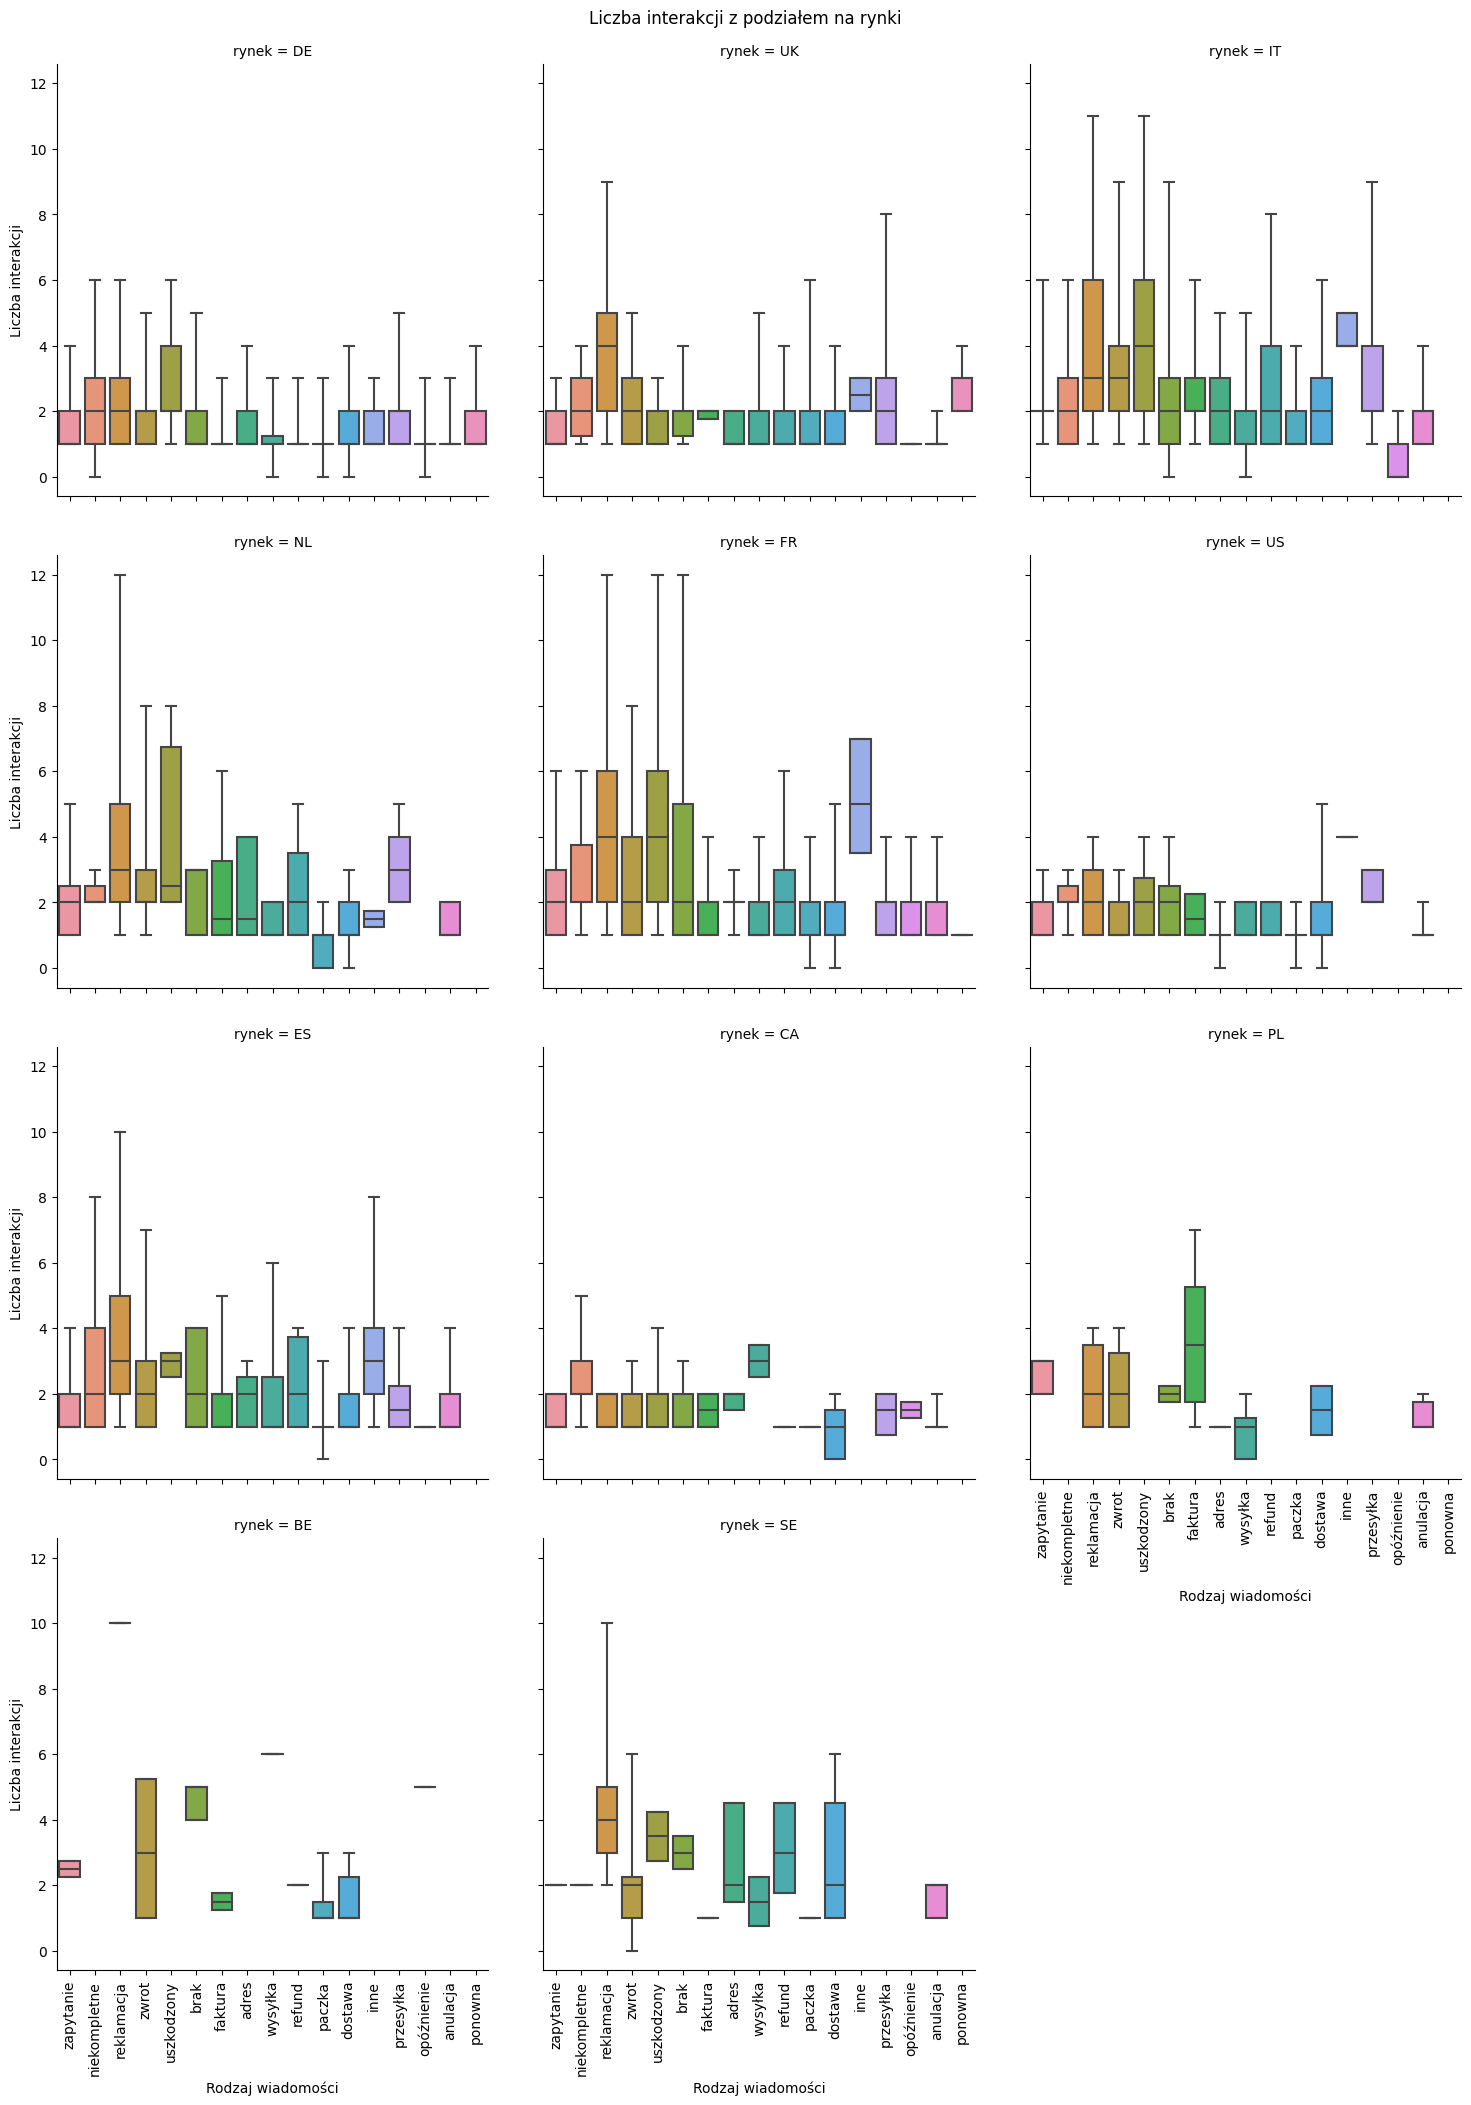

In [170]:
g = sns.catplot(y='Agent interactions',
                x='final_label',
                data=all_cus_go_plots,
                kind='box',
                sym="",
                whis=[5,95],
                col='rynek',
                col_wrap=3)

g.fig.suptitle("Liczba interakcji z podziałem na rynki", y=1.01)
g.set_axis_labels("Rodzaj wiadomości", "Liczba interakcji")

for ax in g.axes.flat:
    plt.sca(ax)
    plt.xticks(rotation=90)

plt.show()

In [171]:
all_cus_go['final_label'].value_counts()

#zaminieć na procenty skupić się na 95%

zwrot           5884
anulacja        5408
reklamacja      4668
dostawa         3741
zapytanie       2632
faktura         1858
wysyłka         1303
paczka          1257
adres            957
brak             824
refund           776
uszkodzony       414
przesyłka        411
niekompletne     395
opóźnienie       292
ponowna          159
inne             127
Name: final_label, dtype: int64

In [172]:
df_to_model = pd.DataFrame()
for i in all_cus_go['final_label'].unique():
    subset = all_cus_go[all_cus_go['final_label'] == i].head(1000).reset_index(drop=True)
    df_to_model = pd.concat([df_to_model, subset], axis=0)

In [173]:
df_to_model['final_label'].value_counts()

zapytanie       1000
faktura         1000
anulacja        1000
dostawa         1000
paczka          1000
wysyłka         1000
zwrot           1000
reklamacja      1000
adres            957
brak             824
refund           776
uszkodzony       414
przesyłka        411
niekompletne     395
opóźnienie       292
ponowna          159
inne             127
Name: final_label, dtype: int64

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [175]:
X = df_to_model['Description']
y = df_to_model['final_label']

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [177]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train)

TfidfVectorizer()

In [178]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [179]:
X_train_tf.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [180]:
tfidf.get_feature_names_out()

array(['00', '000', '0000', ..., 'żądaniem', 'żądanych', 'żę'],
      dtype=object)

In [181]:
pd.DataFrame(X_train_tf.todense(),
             columns=tfidf.get_feature_names_out())

,00,000,0000,0000000,0000028368,0000047237,0000142805,0000357766,0000373427,0000390511,...,żółty,żółtą,żąda,żądają,żądam,żądanej,żądania,żądaniem,żądanych,żę
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:


lr = LogisticRegression()
lr.fit(X_train_tf, y_train)

y_pred = lr.predict(X_test_tf)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       adres       0.76      0.92      0.83       179
    anulacja       0.94      0.90      0.92       168
        brak       0.77      0.79      0.78       156
     dostawa       0.66      0.26      0.37       206
     faktura       0.98      0.95      0.96       214
        inne       1.00      0.41      0.58        27
niekompletne       0.82      0.78      0.79        80
  opóźnienie       0.85      0.60      0.71        58
      paczka       0.87      0.76      0.81       197
     ponowna       0.85      0.74      0.79        38
   przesyłka       0.85      0.71      0.77        78
      refund       0.86      0.82      0.84       152
  reklamacja       0.66      0.78      0.71       212
  uszkodzony       0.77      0.62      0.68        86
     wysyłka       0.52      0.88      0.65       204
   zapytanie       0.86      0.93      0.89       205
       zwrot       0.75      0.75      0.75       211

    accuracy              

In [183]:


rfc = RandomForestClassifier()
rfc.fit(X_train_tf, y_train)

y_pred = rfc.predict(X_test_tf)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:


mnb = MultinomialNB()
mnb.fit(X_train_tf, y_train)

y_pred = mnb.predict(X_test_tf)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       adres       0.79      0.75      0.77       175
    anulacja       0.91      0.93      0.92       185
        brak       0.64      0.54      0.58       169
     dostawa       0.50      0.77      0.60       193
     faktura       0.98      0.91      0.95       227
        inne       0.92      0.48      0.63        25
niekompletne       1.00      0.18      0.30        78
  opóźnienie       0.00      0.00      0.00        11
      paczka       0.80      0.52      0.63       195
   przesyłka       0.96      0.27      0.42        89
      refund       0.88      0.75      0.81       169
  reklamacja       0.55      0.79      0.65       206
  uszkodzony       0.87      0.14      0.25        91
     wysyłka       0.55      0.81      0.66       196
   zapytanie       0.90      0.87      0.88       201
       zwrot       0.52      0.76      0.62       191

    accuracy                           0.70      2401
   macro avg       0.73   

spaCy model

In [ ]:
nlp = spacy.blank("pl")

In [ ]:
df = pd.DataFrame(df_to_model[['Description', 'final_label']])
df.reset_index(inplace=True)

In [ ]:
REGX_URL = r"(https?://|www\.)[^\s/$.?#].[^\s]*"

def preprocessing(text):
  text = text.lower()
  text = text.replace("&quot;", '"')

  text = re.sub(REGX_URL, ' ', text)

  tokens = [token.text for token in nlp(text)]

  tokens = [t for t in tokens if 
              t not in STOP_WORDS and 
              t not in string.punctuation]

  tokens = [t for t in tokens if not t.isdigit()]

  return " ".join(tokens)

In [ ]:
df['Description_cleaned'] = df['Description'].apply(preprocessing)

In [ ]:
y =pd.get_dummies((df['final_label']), prefix='label')
label = list(y.columns)
y = y.to_dict('index')

In [ ]:
dataset = list(zip(df['Description_cleaned'], [{'cats':cats} for cats in y.values()]))
print(dataset[0])

('klient ma pytanie produktu b07r42w8j9 jakie połączenie ma dachówka wentylacyjna link zapytania    pozdrawiam beata', {'cats': {'label_adres': 0, 'label_anulacja': 0, 'label_brak': 0, 'label_dostawa': 0, 'label_faktura': 0, 'label_inne': 0, 'label_niekompletne': 0, 'label_opóźnienie': 0, 'label_paczka': 0, 'label_ponowna': 0, 'label_przesyłka': 0, 'label_refund': 0, 'label_reklamacja': 0, 'label_uszkodzony': 0, 'label_wysyłka': 0, 'label_zapytanie': 1, 'label_zwrot': 0}})


In [ ]:
train_data, test_data = train_test_split(dataset,
                                        test_size=0.25,
                                        random_state=42)
dev_data, test_data = train_test_split(test_data, 
                                       test_size=0.4,
                                       random_state=42)

print(f"Total: {len(dataset)} - Train:  {len(train_data)} - Dev: {len(dev_data)} - Test: {len(test_data)}")

Total: 12001 - Train:  9000 - Dev: 1800 - Test: 1201


In [ ]:
def convert(data, outfile):
    db = spacy.tokens.DocBin()

    for text, labels in data:
        doc = spacy.tokens.Doc(nlp.vocab, words=text.split())
        doc.cats.update(labels['cats'])
        db.add(doc)

    db.to_disk(outfile)

convert(train_data, "./train.spacy")
convert(dev_data, "./dev.spacy")
convert(test_data, "./test.spacy")

In [ ]:
textcat = nlp.add_pipe("textcat_multilabel")
for i in label:
    textcat.add_label(i)

In [ ]:
# ! python -m spacy init fill-config base_config.cfg config.cfg

In [ ]:
# ! python -m spacy train config.cfg --paths.train ./train.spacy  --paths.dev ./dev.spacy --output model --verbose

In [ ]:
# output_dir = 'C:\\Users\\48575\\email_classification\\spaCy_model'
# nlp.to_disk(output_dir)

In [ ]:
saved_model_dir = 'C:\\Users\\48575\\email_classification\\spaCy_model'
nlp = spacy.load(saved_model_dir)

In [ ]:
! python -m spacy evaluate ./model/model-best/ ./test.spacy

ℹ Using CPU

================================== Results ==================================

TOK                   -     
TEXTCAT (macro AUC)   89.75 
SPEED                 175325


=========================== Textcat F (per label) ===========================

                          P       R       F
label_adres           95.05   92.31   93.66
label_anulacja        97.75   95.60   96.67
label_brak            94.74   82.76   88.34
label_dostawa         97.78   46.81   63.31
label_faktura        100.00   98.15   99.07
label_inne           100.00   38.46   55.56
label_niekompletne    94.44   89.47   91.89
label_opóźnienie     100.00   14.29   25.00
label_paczka          98.80   81.19   89.13
label_ponowna          0.00    0.00    0.00
label_przesyłka       94.87   86.05   90.24
label_refund          96.30   92.86   94.55
label_reklamacja      91.86   84.04   87.78
label_uszkodzony      92.31   81.82   86.75
label_wysyłka         95.45   21.00   34.43
label_zapytanie       97.40   80.65 

In [ ]:
def predict_spaCy (text):
    preprocessed_text = preprocessing(text)
    doc = nlp(preprocessed_text)
    label = max(doc.cats, key=doc.cats.get)
    return label

Optimization of Logistic Regression, Random Forest Classifier, and Naive Bayes

In [ ]:
X = df['Description_cleaned']
y = df['final_label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train)

TfidfVectorizer()

In [ ]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [ ]:
X_train_tf.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:


lr = LogisticRegression()
lr.fit(X_train_tf, y_train)

y_pred = lr.predict(X_test_tf)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       adres       0.76      0.89      0.82       175
    anulacja       0.96      0.93      0.94       185
        brak       0.76      0.82      0.79       169
     dostawa       0.68      0.74      0.71       193
     faktura       0.98      0.95      0.96       227
        inne       0.93      0.56      0.70        25
niekompletne       0.83      0.71      0.76        78
  opóźnienie       1.00      0.09      0.17        11
      paczka       0.91      0.75      0.82       195
   przesyłka       0.92      0.63      0.75        89
      refund       0.92      0.86      0.89       169
  reklamacja       0.70      0.77      0.74       206
  uszkodzony       0.83      0.69      0.75        91
     wysyłka       0.77      0.87      0.82       196
   zapytanie       0.84      0.93      0.88       201
       zwrot       0.70      0.74      0.72       191

    accuracy                           0.82      2401
   macro avg       0.84   

In [ ]:
param_grid = {
    'penalty': ['l1','l2','None'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'tol' : [0.001,0.01],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 200],
    'multi_class': ['auto', 'multinomial'],
}

In [ ]:
# searcher=RandomizedSearchCV(lr, param_grid)
# searcher.fit(X_train_tf, y_train)

In [ ]:
# joblib.dump(searcher, "LogisticRegression_randomizedSearchCV")

In [ ]:
searcher = joblib.load("LogisticRegression_randomizedSearchCV")

In [ ]:
print(searcher.best_score_)
print(searcher.best_params_)

0.7918849153934211
{'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'fit_intercept': True, 'C': 10}


In [ ]:
lr = LogisticRegression(tol=0.01, solver='newton-cg', penalty='l2', multi_class='multinomial', 
                        max_iter=200, fit_intercept=True, C=10
                        )
lr.fit(X_train_tf, y_train)

y_pred = lr.predict(X_test_tf)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       adres       0.83      0.88      0.86       175
    anulacja       0.98      0.94      0.96       185
        brak       0.77      0.83      0.80       169
     dostawa       0.68      0.74      0.71       193
     faktura       0.98      0.96      0.97       227
        inne       0.77      0.68      0.72        25
niekompletne       0.82      0.78      0.80        78
  opóźnienie       1.00      0.36      0.53        11
      paczka       0.90      0.79      0.84       195
   przesyłka       0.93      0.75      0.83        89
      refund       0.92      0.89      0.90       169
  reklamacja       0.72      0.77      0.74       206
  uszkodzony       0.88      0.75      0.81        91
     wysyłka       0.80      0.89      0.84       196
   zapytanie       0.88      0.92      0.90       201
       zwrot       0.74      0.74      0.74       191

    accuracy                           0.84      2401
   macro avg       0.85   

In [ ]:

rfc = RandomForestClassifier()
rfc.fit(X_train_tf, y_train)

y_pred = rfc.predict(X_test_tf)



print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       adres       0.75      0.89      0.81       175
    anulacja       0.94      0.94      0.94       185
        brak       0.77      0.79      0.78       169
     dostawa       0.66      0.68      0.67       193
     faktura       0.97      0.95      0.96       227
        inne       1.00      0.56      0.72        25
niekompletne       0.88      0.77      0.82        78
  opóźnienie       1.00      0.36      0.53        11
      paczka       0.87      0.67      0.76       195
   przesyłka       0.89      0.57      0.70        89
      refund       0.92      0.88      0.90       169
  reklamacja       0.66      0.72      0.69       206
  uszkodzony       0.81      0.73      0.77        91
     wysyłka       0.88      0.88      0.88       196
   zapytanie       0.80      0.90      0.85       201
       zwrot       0.58      0.70      0.63       191

    accuracy                           0.80      2401
   macro avg       0.84   

In [ ]:
param_grid = {
    'n_estimators': [50, 125, 200],  # Range of values for n_estimators
    'max_depth': [None, 5, 13, 20],  # Including None for no max depth
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

In [ ]:
# searcher=RandomizedSearchCV(rfc, param_grid)
# searcher.fit(X_train_tf, y_train)

In [ ]:
# joblib.dump(searcher, "RandomForestClassifier_randomizedSearchCV")

In [ ]:
searcher = joblib.load("LogisticRegression_randomizedSearchCV")

In [ ]:
print(searcher.best_score_)
print(searcher.best_params_)

0.7918849153934211
{'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'fit_intercept': True, 'C': 10}


In [ ]:
# rfc = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=None, criterion='gini')
# rfc.fit(X_train_tf, y_train)

# y_pred = rfc.predict(X_test_tf)

# from sklearn.metrics import classification_report

# print(classification_report(y_test, y_pred))